In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.cluster import KMeans
import untangle
import tifffile
import warnings
from read_roi import read_roi_zip
from utils.MastodonFunctions import xml_features, csv_features, ordering_tracks, smoothing_filter, peak_detection

# Figure 1 A-E: In vivo Her 1 Data

For Figure 1 A-E, we use the data from one 15 somite stage embryo - a looping transgenic (Her1-YFP). Several cells were backtracked from one somite all the way until the Tailbud and some others backtracked from the posterior PSM until the TB. Here show the dynamics of these cells, as well as some quantitaive results on the osillatory behaviour. 


<a id='top'></a>

[0] [Data Import](#import): We import the .xml (time-lapse metadata), .csv (mastodon tracks) and the .roi (segmented notochord) for the analysis we will perform in this notebook. We also arrange the tracks according to their IDs. 

[1] [Spatial Analysis](#space): Project the cells into the segmented Nothocord (upload the .zip with the LOIs) in order to have the dynamics of the cells in the Anterior-Posterior axis.

[2] [Cells projected into a Max Projection](#max): To observe how the cells behave in the tissue in the XY coordinates, we project the cells into a Max projection and check different timepoints. 

### Import data

<a id='import'></a>

The .xml file contains all the metadata from the movie: pixel size in XYZ, number of channels, total number of frames, width and height of the image... 

The .csv file contains the tracked data from Mastodon. Using the MastodonFunctions we reorganize the data in a way that we can separate by channel, by position, by intensity, by cell division and by time each individual cell. 

In [2]:
# Path to the .xml file
path_xml = '../Data/Figure 1/Figure 1A-E/Position2_20191213.xml' # Path to .xml file

# Path to the -edges.csv amd -vertices.csv files (You only need path + name of file without the -edges or -vertices extension)
path_csv = '../Data/Figure 1/Figure 1A-E/Position2_TB_to_TB_PSM_SOM' #Position2-somite' 

# Path to the ROI zip
path_roi = '../Data/Figure 1/Figure 1A-E/RoiSet-Position2.zip' 

# Path to the Max-Projections
path_tif = '../Data/Figure 1/Figure 1A-E'

### Image characteristics

In [3]:
# Time resolution in seconds (how often do you acquire time points)
tr = 90
tr_min = tr/60
fts = xml_features(path_xml)

# Features from the image obtained from the .xml generated by BigData Viewer
print('The image has the following dimensions (XYZC): %d, %d, %d, %d'%(fts.width, fts.height, fts.n_slices, fts.channels))
print('There are %d frames in total.'%fts.n_frames)
print('Pixel Size: x = %.3g %s, y = %.3g %s z = %.2g %s'%(fts.x_pixel, fts.units, fts.y_pixel, fts.units, fts.z_pixel, fts.units))
print('There are %d Z-slices in total'%fts.n_slices)

The image has the following dimensions (XYZC): 2048, 2048, 150, 2
There are 299 frames in total.
Pixel Size: x = 0.347 micron, y = 0.347 micron z = 1.5 micron
There are 150 Z-slices in total


### Obtain the single cell tracks

**spots:** dictionary which contains all the features for each cell as an individual cell. For each cell it has the following information: 
- IDs (individual for each cell)
- Track IDs (individual for each track - all cells in the same trace will have this same ID)
- Frames
- Mean
- Median
- Standard deviation
- Number of links
- Number of spots
- Number of tracks
- Position (X,Y,Z)
- Spot source and target (this is useful for when we try to reconstruct the tracking sequence for each spot)
- Spots tag and subtag

**tracks:** dictionary contains the information on each trace - the already reconstructed tracks. It consists on the following information:
- Number of division tracks: How many cells divide
- Number of total tracks 
- spots features: This dictionary contains the frames, mean, median, ID, XYZ position and the ID for each division for each cell trace

In [4]:
spots = csv_features(path_csv, path_xml)
tracks = ordering_tracks(path_csv, path_xml)

### Data alignment

We align every trace to make sure every trace has its corresponding time vector. This is important since not all of the cells have been tracked from the same initial timepoint. 

In [5]:
# Obtain the subtags from the somite tag

TBSOM25 = []
TBPSMd = []
TBTB = []

tags_all = np.array(['TBto SOM25', 'TBtoPSMd', 'TBtoTB'])

  
# Initialize a dictionary to save cell tracks according to the somite where they end up
mean1 = {key: [] for key in tags_all} # Save the mean intensity values
frames = {key: [] for key in tags_all} # Save the frames 
x = {key: [] for key in tags_all} # Save x-coords
y = {key: [] for key in tags_all} # Save y-coords
z = {key: [] for key in tags_all} # Save z-coords

tag_save = np.zeros(tracks.n_tracks_divs)
ids_save = {key: [] for key in tags_all}

# Analysis of cells thast do not end up in the same somite
for k in range(len(tags_all)):
    
    for j in range(tracks.n_tracks_divs):
        # Which is the last subtag in the list 
        ind_somite = tracks.spots_tags[tags_all[k]][j][0]
        
        # If it is different from 0, there is a tag!
        if ind_somite!='0.0': 
            mean1[tags_all[k]].append(tracks.spots_features['Mean1'][j])
            frames[tags_all[k]].append(tracks.spots_features['Frames'][j])
            x[tags_all[k]].append(tracks.spots_features['X'][j])
            y[tags_all[k]].append(tracks.spots_features['Y'][j])
            z[tags_all[k]].append(tracks.spots_features['Z'][j])
            ids_save[tags_all[k]].append(tracks.spots_features['ID'][j])
            tag_save[j] = int(np.where(tags_all == tags_all[k])[0])

## Cell 36 has the wrong tag, it is actually TB to PSMd
tag_save[36] = 1.0

### Obtain mean, median and standard deviations

We will use the mean to show the dynamics of the cells on average and also, to perform the peak analysis to obtain the periodicity.

*Ignore the warning*

In [6]:
grouped_cells = []
mean_vals = []
median_vals = []
std_vals = []
for j in range(2):
    inds = np.where(tag_save==j)[0]
    aux = np.zeros((len(inds), fts.n_frames))*np.nan
    for i,cell in enumerate(inds):
        for tps, tps_val in enumerate(tracks.spots_features['Frames'][cell]):
            aux[i, tps_val] = tracks.spots_features['Mean1'][cell][tps]
            
    # Because we sometimes to a mean or median or std os an all NaN list, we catch the warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        grouped_cells.append(aux)
        mean_vals.append(np.nanmean(aux, axis=0))
        median_vals.append(np.nanmedian(aux, axis=0))
        std_vals.append(np.nanstd(aux, axis=0))

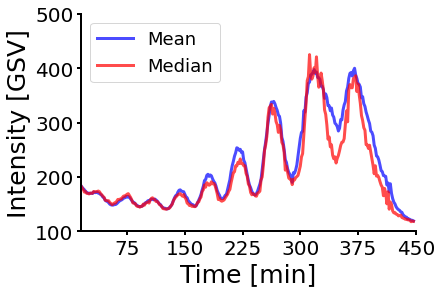

In [7]:
plt.plot(mean_vals[0], color='blue', linewidth=3, alpha=0.7, label='Mean')
plt.plot(median_vals[0], color='red', linewidth=3, alpha=0.7, label='Median')

#plt.plot(mean_vals, color='black', linewidth=3, linestyle='dashed')
plt.xlabel('Time [min]', fontsize=25)
locs, labels = plt.xticks()
plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=20)
plt.yticks(np.arange(100,600,100), fontsize=20)
plt.ylabel('Intensity [GSV]', fontsize=25)
plt.xlim([10,300])
plt.legend(loc='best', fontsize=18)

ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

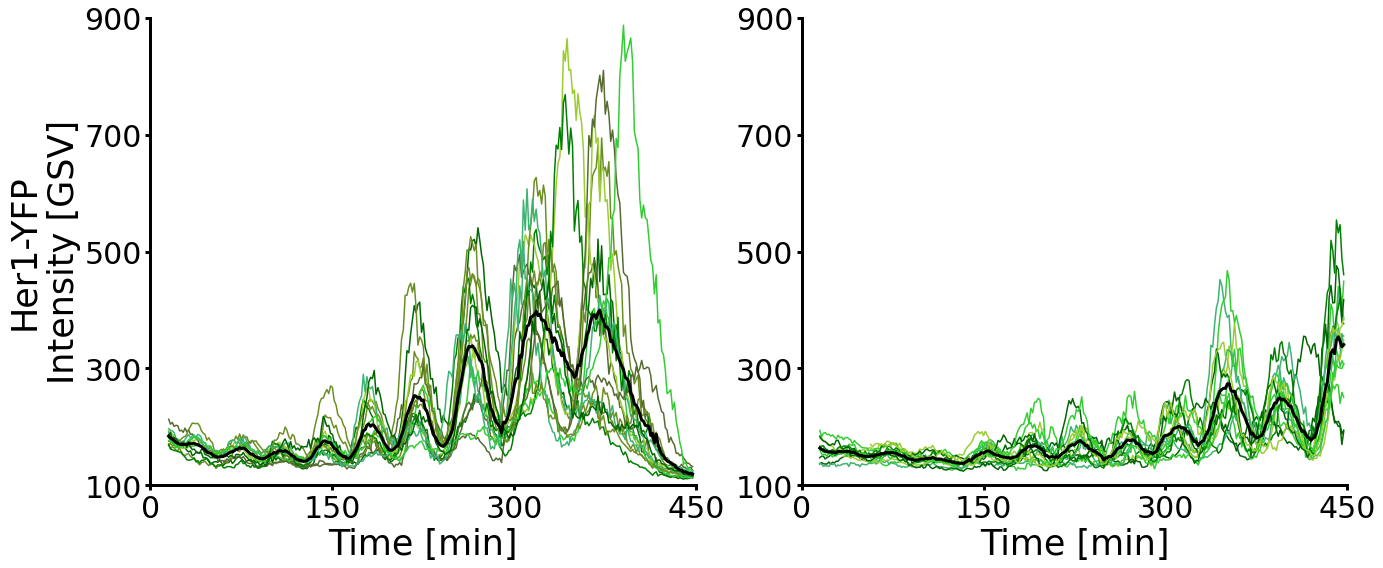

In [8]:
# Plot accorsing to somite

# Define the dimensions of the subplot
n_cells = len(tags_all) 
n_cols = 4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

titles = ['TB to Somite', 'TB to PSM4']

# Initialize the figure size
fig = plt.figure(figsize=[37,8])

colors1 = ['green', 'limegreen', 'darkgreen', 'mediumseagreen', 'yellowgreen', 'darkolivegreen',
         'olivedrab']*10

med_cols = ['green', 'blue']


for j,val in enumerate(np.array(tags_all)[:-1]):
    
    # Update the number of subplots    
    plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    inds = np.where(tag_save==j)[0]
    for i in inds:
        plt.plot(tracks.spots_features['Frames'][i]*tr_min, tracks.spots_features['Mean1'][i], 
                 linewidth=1.5, color=colors1[i])
   
    plt.plot(np.arange(fts.n_frames)*tr_min, mean_vals[j], linewidth=3, color='black')
    plt.xlabel('Time [min]', fontsize=35)
    plt.xticks(np.arange(0,500,150), fontsize=30)
    plt.xlim([0,450])
    plt.ylim([100,900])
    
    if j == 0:
        plt.yticks(np.arange(100,1000,200), fontsize=30)
        plt.ylabel('Her1-YFP\nIntensity [GSV]', fontsize=35)
    else:
        plt.yticks(np.arange(100,1000,200), fontsize=30)

    
    
    ax = plt.gca()
    ax.tick_params(width=3, length=5)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 1/Figure 1A-E/Results/Traces_Her1.pdf', bbox_inches='tight')

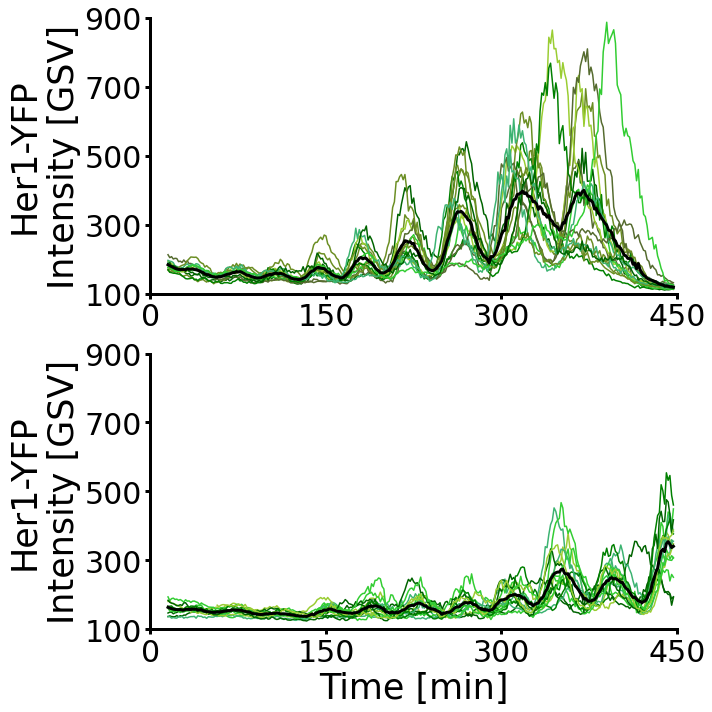

In [17]:
# Plot accorsing to somite

# Define the dimensions of the subplot
n_cells = len(tags_all) 
n_cols = 1
n_rows = 2
plot_num = 1

titles = ['TB to Somite', 'TB to PSM4']

# Initialize the figure size
fig = plt.figure(figsize=[10,10])

colors1 = ['green', 'limegreen', 'darkgreen', 'mediumseagreen', 'yellowgreen', 'darkolivegreen',
         'olivedrab']*10

med_cols = ['green', 'blue']


for j,val in enumerate(np.array(tags_all)[:-1]):
    
    # Update the number of subplots    
    plt.subplot(int(n_rows), n_cols, plot_num)
    plot_num += 1
    
    inds = np.where(tag_save==j)[0]
    for i in inds:
        plt.plot(tracks.spots_features['Frames'][i]*tr_min, tracks.spots_features['Mean1'][i], 
                 linewidth=1.5, color=colors1[i])
   
    plt.plot(np.arange(fts.n_frames)*tr_min, mean_vals[j], linewidth=3, color='black')

    plt.yticks(np.arange(100,1000,200), fontsize=30)
    plt.ylabel('Her1-YFP\nIntensity [GSV]', fontsize=35)
    plt.xlim([0,450])
    plt.ylim([100,900])
    
    if j == 1:
        plt.xlabel('Time [min]', fontsize=35)
        plt.xticks(np.arange(0,500,150), fontsize=30)
    else:
        plt.xticks(np.arange(0,500,150), fontsize=30)

    
    
    ax = plt.gca()
    ax.tick_params(width=3, length=5)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 1/Figure 1A-E/Results/Traces_Her1_vertical.pdf', bbox_inches='tight')

In [ ]:
## Plot accorsing to somite

# Define the dimensions of the subplot
n_cells = len(tags_all) 
n_cols = 4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

titles = ['TB to Somite', 'TB to PSM4']

# Initialize the figure size
fig = plt.figure(figsize=[60,8])

colors1 = ['green', 'limegreen', 'darkgreen', 'mediumseagreen', 'yellowgreen', 'darkolivegreen',
         'olivedrab']*10

med_cols = ['green', 'blue']


for j,val in enumerate(np.array(tags_all)[:-1]):
    
    # Update the number of subplots    
    plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    inds = np.where(tag_save==j)[0]
    for i in inds:
        plt.plot(tracks.spots_features['Frames'][i]*tr_min, tracks.spots_features['Mean1'][i], 
                 linewidth=1.5, color=colors1[i])
   
    plt.plot(np.arange(fts.n_frames)*tr_min, mean_vals[j], linewidth=3, color='black')
    plt.xlabel('Time [min]', fontsize=35)
    plt.xticks(np.arange(0,500,150), fontsize=30)
    plt.xlim([0,450])
    plt.ylim([100,900])
    
    if j == 0:
        plt.yticks(np.arange(100,1000,200), fontsize=30)
        plt.ylabel('Her1-YFP\nIntensity [GSV]', fontsize=35)
    else:
        plt.yticks(np.arange(100,1000,200), fontsize=30)

    
    
    ax = plt.gca()
    ax.tick_params(width=3, length=5)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../../Figures Linked Alt Version Nov 2021/ABR_Edits/Traces_Her1.pdf', bbox_inches='tight')

#### Zoom in of the TB region

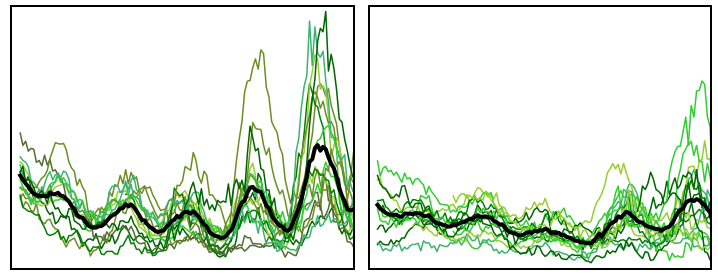

In [9]:
# Plot accorsing to somite

# Define the dimensions of the subplot
n_cells = len(tags_all) 
n_cols = 4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

titles = ['TB to Somite', 'TB to PSM4']

# Initialize the figure size
fig = plt.figure(figsize=[20,4])

colors1 = ['green', 'limegreen', 'darkgreen', 'mediumseagreen', 'yellowgreen', 'darkolivegreen',
          'olivedrab']*10

colors = [colors1, colors1]
for j,val in enumerate(np.array(tags_all)[:-1]):
    
    # Update the number of subplots    
    plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
    plot_num += 1
    
    inds = np.where(tag_save==j)[0]
    for i in inds:
        plt.plot(tracks.spots_features['Frames'][i]*tr_min, tracks.spots_features['Mean1'][i], 
                 linewidth=1.5, color=colors1[i])
    
    plt.plot(np.arange(fts.n_frames)*tr_min, mean_vals[j], linewidth=4, color='black')

    plt.xticks([])
    plt.yticks([])

    plt.xlim([10,200])
    plt.ylim([120,300])
    
    
    ax = plt.gca()
    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 1/Figure 1A-E/Results/Zoom_Traces_Her1.pdf', bbox_inches='tight')

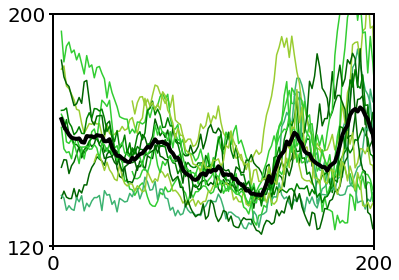

In [21]:
# Plot accorsing to somite

# Define the dimensions of the subplot
n_cells = len(tags_all) 
n_cols = 4
n_rows = np.ceil((n_cells + 1) / n_cols)
plot_num = 1

titles = ['TB to Somite', 'TB to PSM4']

# Initialize the figure size
fig = plt.figure(figsize=[20,4])

colors1 = ['green', 'limegreen', 'darkgreen', 'mediumseagreen', 'yellowgreen', 'darkolivegreen',
          'olivedrab']*10

colors = [colors1, colors1]

j=1   
# Update the number of subplots    
plt.subplot(int(n_rows), n_cols, plot_num, aspect='auto')
plot_num += 1

inds = np.where(tag_save==j)[0]
for i in inds:
    plt.plot(tracks.spots_features['Frames'][i]*tr_min, tracks.spots_features['Mean1'][i], 
             linewidth=1.5, color=colors1[i])

plt.plot(np.arange(fts.n_frames)*tr_min, mean_vals[j], linewidth=4, color='black')

plt.xticks([10,200], [0, 200], fontsize=20)
plt.yticks([120, 200], fontsize=20)

plt.xlim([10,200])
plt.ylim([120,200])
    
    
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 1/Figure 1A-E/Results/Zoom_Traces_Her1-TBPSM.pdf', bbox_inches='tight')

### Peaks for the mean traces

We manually selected the troughs for the mean traces for both groups (TB to Somite and TB to PSM). Below we show the selected troughs. We decided to use the troughs to calculate the period as trough-to-trough distance so that we can include the last cycle in the measurement. 

In [11]:
peak_time = np.load('../Data/Figure 1/Figure 1A-E/peak_time.npy', allow_pickle=True)
min_val = np.load('../Data/Figure 1/Figure 1A-E/min_val.npy', allow_pickle=True)

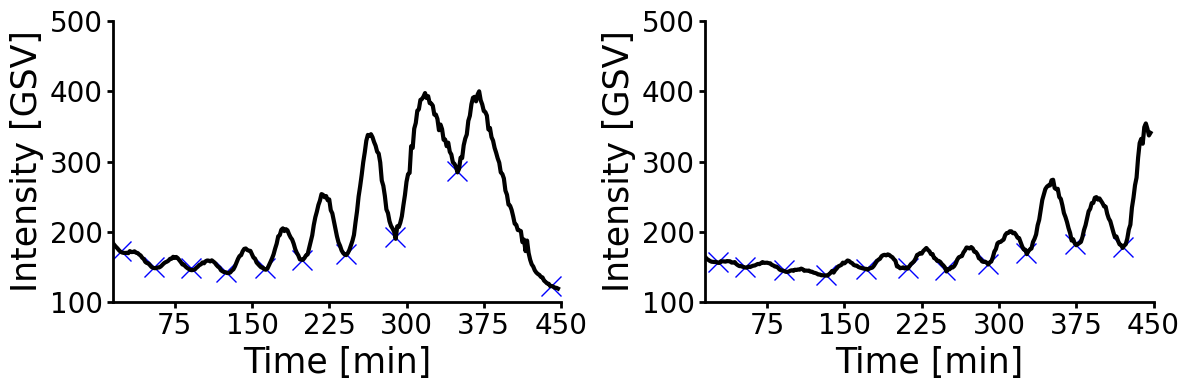

In [12]:
window = 2

plt.style.use('default')

ind = 0

plot_num = 1

# Initialize the figure size
ax = plt.figure(figsize=[12,4])
titles = ['TB-Somite', 'TB-PSM4']
#for j in range(tracks.n_tracks_divs):
for j in range(2):    
   
    # Update the number of subplots    
    ax = plt.subplot(1, 2, plot_num, aspect='auto')
    plot_num += 1

    # Correct for the last peak in case it was not detected:
    y = smoothing_filter(mean_vals[j], window)

    plt.plot(peak_time[j], min_val[j], "xb", markersize=15);  plt.plot(y, color='black', linewidth=3); 
    plt.xlabel('Time [min]', fontsize=25)
    locs, labels = plt.xticks()
    plt.xticks(locs, map(int,np.round(locs*tr_min)), fontsize=20)
    plt.yticks(np.arange(100,600,100), fontsize=20)
    plt.ylabel('Intensity [GSV]', fontsize=25)
    plt.xlim([10,300])
    
    ax = plt.gca()
    ax.tick_params(width=2, length=4)
    ax.spines['top'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(0)

plt.tight_layout()




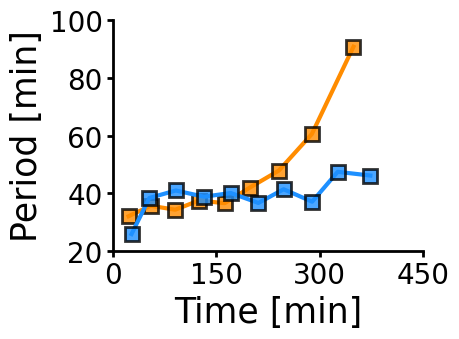

In [13]:
fig = plt.figure(figsize=[4,3])
plt.plot(peak_time[0][:-1]*tr_min, np.diff(peak_time[0])*tr_min, linewidth=3, label='TB-Somite', color='darkorange')
plt.plot(peak_time[0][:-1]*tr_min, np.diff(peak_time[0])*tr_min, marker='s', markeredgewidth=2, markersize=10, markeredgecolor='k', color='darkorange', alpha=0.8)

plt.plot(peak_time[1][:-1]*tr_min, np.diff(peak_time[1])*tr_min, linewidth=3, label='TB-PSM4', color='dodgerblue')
plt.plot(peak_time[1][:-1]*tr_min, np.diff(peak_time[1])*tr_min, marker='s', markeredgewidth=2, markersize=10, markeredgecolor='k', color='dodgerblue', alpha=0.8)

plt.xlabel('Time [min]', fontsize=25)
plt.xticks(np.arange(0,500,150), fontsize=20)
plt.yticks(np.arange(20,105,20), fontsize=20)
plt.ylabel('Period [min]', fontsize=25)
plt.xlim([0,450])
#plt.ylim([100,800])
#plt.legend(loc='best', fontsize=16)


ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

## Spatial Analyisis

<a id='space'></a>

If you want to go to the top of the notebook click here: [Top](#top)

### Reorganize the data 

In [14]:
# Align using their temporal position

tracks_save = []
frames_save = []

# Fill the timepoints where there are no cells tracked with nan
tracks_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan
frames_save = np.ones((tracks.n_tracks_divs, fts.n_frames))*np.nan

# For each track 
for i in range(tracks.n_tracks_divs):

    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(tracks.spots_features['Frames'][i]):
        tracks_save[i,val] = tracks.spots_features['Mean1'][i][j]

    
# If there is a nan, add an average number in between 

for i in range(tracks.n_tracks_divs):
    # Where the track starts
    init_tp = tracks.spots_features['Frames'][i][0]
    for j in range(init_tp,fts.n_frames-1):
        count = 1
        var = True
        
        while var == True:
            x = tracks_save[i][j]
            y = tracks_save[i][j+count]

            if (np.isnan(x)==False and np.isnan(y)==True):
                tracks_save[i][j+count] = x
                var = False
            if (np.isnan(x)==True and np.isnan(y)==False):
                tracks_save[i][j:j+count] = y
                var = False
            if (np.isnan(x)==True and np.isnan(y)==True):
                count +=1
            if (np.isnan(x)==False and np.isnan(y)==False):
                var = False

In [15]:
trace_save = []
frames_save = []
div_save = []
x_save_ = []
y_save_ = []
z_save_ = []
id_save = []

for j in range(tracks.n_tracks_divs):

    trace_save.append(tracks.spots_features['Mean1'][j])
    frames_save.append(tracks.spots_features['Frames'][j])
    x_save_.append(tracks.spots_features['X'][j])
    y_save_.append(tracks.spots_features['Y'][j])
    z_save_.append(tracks.spots_features['Z'][j])
    div_save.append(tracks.spots_features['DivID'][j])
    id_save.append(tracks.spots_features['ID'][j])

In [16]:
n_cells = len(frames_save)

# Fill the timepoints where there are no cells tracked with nan
tracks_save = np.ones((n_cells, fts.n_frames))*np.nan

# Save also the x,y positions
x_save = np.ones((n_cells, fts.n_frames))*np.nan
y_save = np.ones((n_cells, fts.n_frames))*np.nan
z_save = np.ones((n_cells, fts.n_frames))*np.nan

# For each track 
for i in range(n_cells):
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(frames_save[i]):
        tracks_save[i,val] = trace_save[i][j]
        x_save[i,val] = x_save_[i][j]
        y_save[i,val] = y_save_[i][j]
        z_save[i,val] = z_save_[i][j]

### Remove Time registration from the cells coordinates

Because we applied a time registration into our timelapse, Mastodon return registered coordinates. However, since we want to compare them to the Notochord (our LOI - line of interest) and also plot them on top of Max projections (from the raw timelapse), we need to return to the original coordinate system. 

In [17]:
obj = untangle.parse(path_xml)

x_save_r = []
y_save_r = []
z_save_r = []
    
for j in range(n_cells):
    
    aux_x = []
    aux_y = []
    aux_z = []
    
    for i in range(0,(fts.n_frames)*fts.channels,fts.channels):
        
        # XYZ coordinates from mastodon
        xyz_coord = np.array([x_save[j][int(i/2)],y_save[j][int(i/2)],z_save[j][int(i/2)]]).reshape(-1,1)
    
        # Registration from .xml
        registration = np.array(obj.SpimData.ViewRegistrations.ViewRegistration[i].ViewTransform[0].affine.cdata.split(),dtype=float).reshape(3,4)
        
        # Rotation matrix
        R = registration[:,:3] 
        
        # Inverse of rotation matrix
        R_inv = np.linalg.inv(R)
        
        # Translation matrix
        T = registration[:,-1].reshape(-1,1)
        
        final = R_inv@(xyz_coord-T)
        
        # Save xyz de-registered coordinates
        aux_x.append(final[0][0])
        aux_y.append(final[1][0])
        aux_z.append(final[2][0])

    x_save_r.append(aux_x)
    y_save_r.append(aux_y)
    z_save_r.append(aux_z)

## Notochord

Import the notochord LOI segmentation in order to use this as out new AP (anterior-posterior) axis. This way we will be able to see how the cells are moving over time within this axis. 

In [18]:
# Read all the ROIs
rois = read_roi_zip(path_roi)

# Number of timepoints
time_points = len(rois)

# Number of points in each segmented notochord line
notochord_points = 32

# Name of ROIs per time point
name_rois = list(rois.keys())

# Initialize where to save the coordinates
x_coords_not = np.zeros((time_points, notochord_points))
y_coords_not = np.zeros((time_points, notochord_points))

for j in range(len(rois)):

    # To know in which frame the analysis happened
    #frame = rois[name_rois[j]]['position']-1 #['frame']-1
    frame = int(rois[name_rois[j]]['name'][:4])-1
    
    x_coords_not[frame,:] = rois[name_rois[j]]['x']
    y_coords_not[frame,:] = rois[name_rois[j]]['y']

### Equidistant points to increase spatial resolution

Because we only took 32 points to segment the Notochord, we increase the resolution by adding points between the ones we already have. 

*The Notochord was segmented using the [segmented line tool](https://imagej.nih.gov/ij/docs/tools.html) from Fiji. The result was saved using the [ROI manager](https://imagej.nih.gov/ij/docs/guide/146-30.html)*

In [19]:
def getEquidistantPoints(p1, p2, parts):
    return zip(np.linspace(p1[0], p2[0], parts+1), np.linspace(p1[1], p2[1], parts+1))

list(getEquidistantPoints((1,1), (5,5), 4))[0]

x_not_equidist = []
y_not_equidist = []
n_points = 20 # Number of points to add 

for i in range(time_points):
    
    # Initial number of points from fiji
    x = x_coords_not[i].astype(int)
    y = y_coords_not[i].astype(int)
    
    x_aux = []
    y_aux = []
    
    for j in range(notochord_points-1):
        aux = list(getEquidistantPoints((x[j],y[j]),(x[j+1],y[j+1]), n_points))
        
        # For each of the inserted points
        for k in range(len(aux)-1):
            x_aux.append(aux[k][0])
            y_aux.append(aux[k][1])
            
    x_not_equidist.append(x_aux)
    y_not_equidist.append(y_aux)
    
print('Number of timepoints: %d'%np.shape(x_not_equidist)[0])
print('Number of points per timepoint: %d'%np.shape(x_not_equidist)[1])

Number of timepoints: 300
Number of points per timepoint: 620


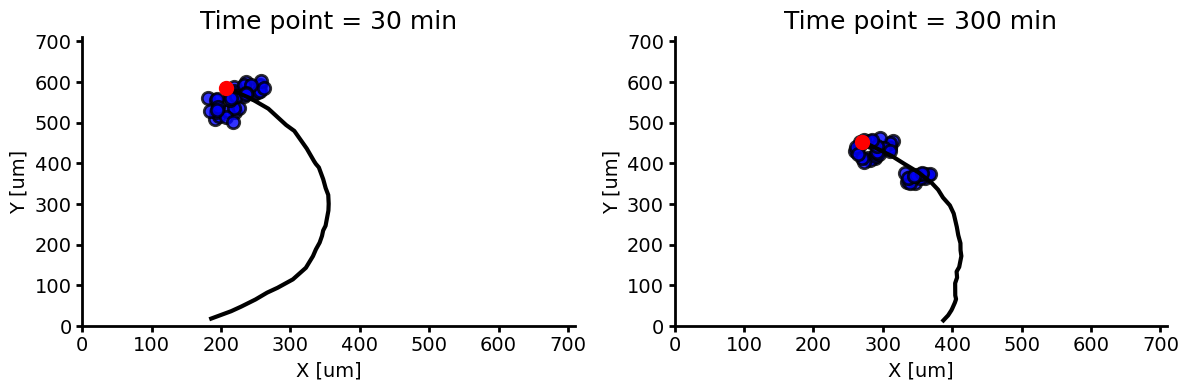

In [20]:
plt.figure(figsize=[12,4])
plt.subplot(121)
tp = 20
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
    plt.scatter(x_save_r[j][tp],y_save_r[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

plt.subplot(122)
tp = 200
plt.plot(np.array(x_not_equidist[tp])*fts.x_pixel, (np.array(y_not_equidist[tp]))*fts.y_pixel, linewidth=3, color='black')
plt.plot(x_not_equidist[tp][0]*fts.x_pixel,(y_not_equidist[tp][0])*fts.y_pixel,'o',color='red', markersize=10)

for j in range(n_cells):
     plt.scatter(x_save_r[j][tp],y_save_r[j][tp], c='blue', edgecolor='black', linewidth=2, s=80, alpha=0.8)

plt.xlim([0,2048*fts.x_pixel])
plt.ylim([0,2048*fts.y_pixel])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('X [um]', fontsize=14)
plt.ylabel('Y [um]', fontsize=14)
ax = plt.gca()
ax.tick_params(width=2, length=4)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(0)

plt.title('Time point = %d min'%(tp*tr_min), fontsize=18)

plt.tight_layout()
plt.show()

The red spot represents our reference point, the tip of the Tailbud (the most posterior point). The black line is the notochord and the blue spots are all of the cells. 

### Project the positions into the line of reference: the notochord

We use the most posterior point as out 0 position, meaning that the closer to the tailbud, the smaller the distance to the reference will be. 

In [21]:
# Projection function

def projectionNotochord(x,y,x_not,y_not):
    # Reference pointa
    x_0 = x_not[0]
    y_0 = y_not[0]
    
    # Calculate the projection to the notochord line
    ind_proj = np.argmin(np.sqrt((x-x_not)**2+(y-y_not)**2))
    
    # Calculate the distance from the projection to the reference point
    distance_to_ref = np.sqrt((x_not[ind_proj]-x_0)**2+(y_not[ind_proj]-y_0)**2)
    
    return distance_to_ref

In [22]:
# Project the rest of the cells
proj_dist_all = []

# For each cell tracked
for i in range(n_cells):
    
    distance = []
    
    # For each of the timepoints
    for j in frames_save[i]:
        
        # Find the projected value
        distance.append(projectionNotochord(x_save_r[i][j], y_save_r[i][j],\
                                np.array(x_not_equidist[j])*fts.x_pixel, \
                                            np.array(y_not_equidist[j])*fts.x_pixel))

    proj_dist_all.append(distance)
    
# Because they all have different sizes, make them all have the same length for simplicity for later computations
proj_save = np.ones((n_cells, fts.n_frames+1))*np.nan

# For each track 
for i in range(n_cells):
    # Add the tracked spot to the specific time frame to which it corresponds
    for j,val in enumerate(frames_save[i]):
        proj_save[i,val] = proj_dist_all[i][j]

In [23]:
mean_vals_g = []
median_vals_g = []
std_vals_g = []

for k in range(len(tags_all)):
    mean_vals_aux = []
    median_vals_aux = []
    std_vals_aux = []
    
    for i in range(fts.n_frames):
        cells_aux = []
        
        cells = np.where(tag_save==k)[0]
        
        for j in cells:
            cells_aux.append(proj_save[j][i])
        
        # Because we sometimes to a mean or median or std os an all NaN list, we catch the warning
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            mean_vals_aux.append(np.nanmean(cells_aux))
            median_vals_aux.append(np.nanmedian(cells_aux))
            std_vals_aux.append(np.nanstd(cells_aux))
    
    mean_vals_g.append(np.array(mean_vals_aux)[~np.isnan(np.array(mean_vals_aux))])
    median_vals_g.append(median_vals_aux)
    std_vals_g.append(np.array(std_vals_aux)[~np.isnan(np.array(std_vals_aux))])

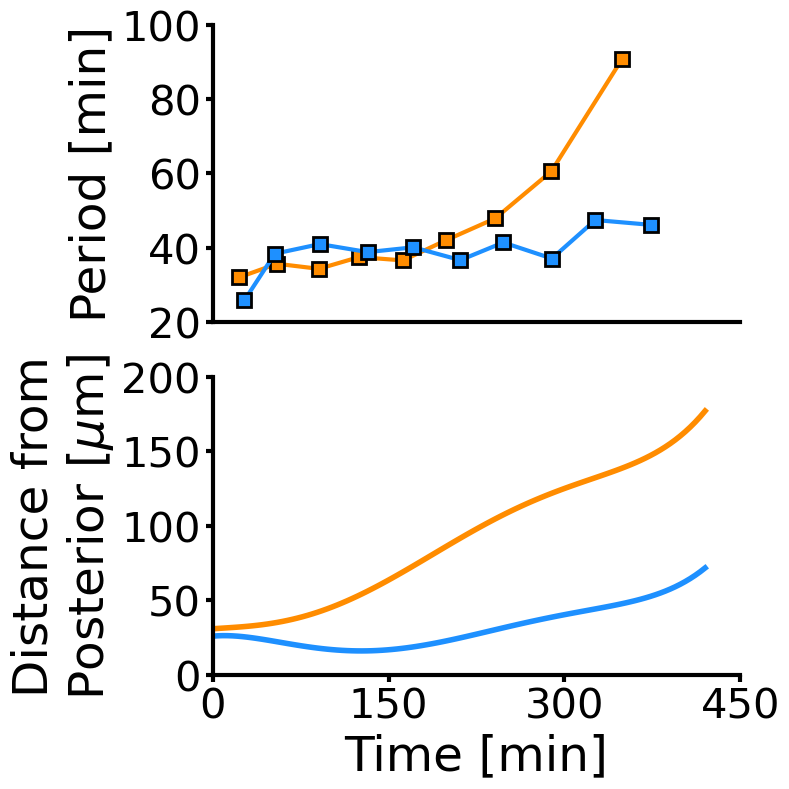

In [24]:
k = 0
deg = [5,5,3]
cols1 = ['darkorange', 'dodgerblue', 'deepskyblue']
fig = plt.figure(figsize=[8,8])

plt.subplot(212)
for k in range(2):
    x = np.arange(len(mean_vals_g[k]))*tr_min
    y = mean_vals_g[k]
    z = np.polyfit(x, y, deg[k])

    p = np.poly1d(z)
    xp = np.linspace(0,420,100)

    plt.plot(xp, p(xp), linewidth=4, color=cols1[k]) 
   

    #plt.axvline(75, linestyle='dashed')
plt.xlabel('Time [min]', fontsize=35)
plt.xticks(np.arange(0,550,150), fontsize=30)
plt.yticks(np.arange(0,250,50), fontsize=30)
plt.ylabel('Distance from\nPosterior [$\mu$m]', fontsize=35)
plt.xlim([0,450])
plt.ylim([0,200])


ax = plt.gca()
ax.tick_params(width=3, length=5)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(0)

plt.subplot(211)

plt.plot(peak_time[0][:-1]*tr_min, np.diff(peak_time[0])*tr_min, linewidth=3, label='TB-Somite', color='darkorange')
plt.plot(peak_time[0][:-1]*tr_min, np.diff(peak_time[0])*tr_min, marker='s', markeredgewidth=2, markersize=10, markeredgecolor='k', color='darkorange', alpha=1)

plt.plot(peak_time[1][:-1]*tr_min, np.diff(peak_time[1])*tr_min, linewidth=3, label='TB-PSM4', color='dodgerblue')
plt.plot(peak_time[1][:-1]*tr_min, np.diff(peak_time[1])*tr_min, marker='s', markeredgewidth=2, markersize=10, markeredgecolor='k', color='dodgerblue', alpha=1)


plt.xticks([])
plt.yticks(np.arange(20,105,20), fontsize=30)
plt.ylabel('Period [min]', fontsize=35)
plt.xlim([0,450])


ax = plt.gca()
ax.tick_params(width=3, length=5)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../Data/Figure 1/Figure 1A-E/Results/Movement.pdf', bbox_inches='tight')

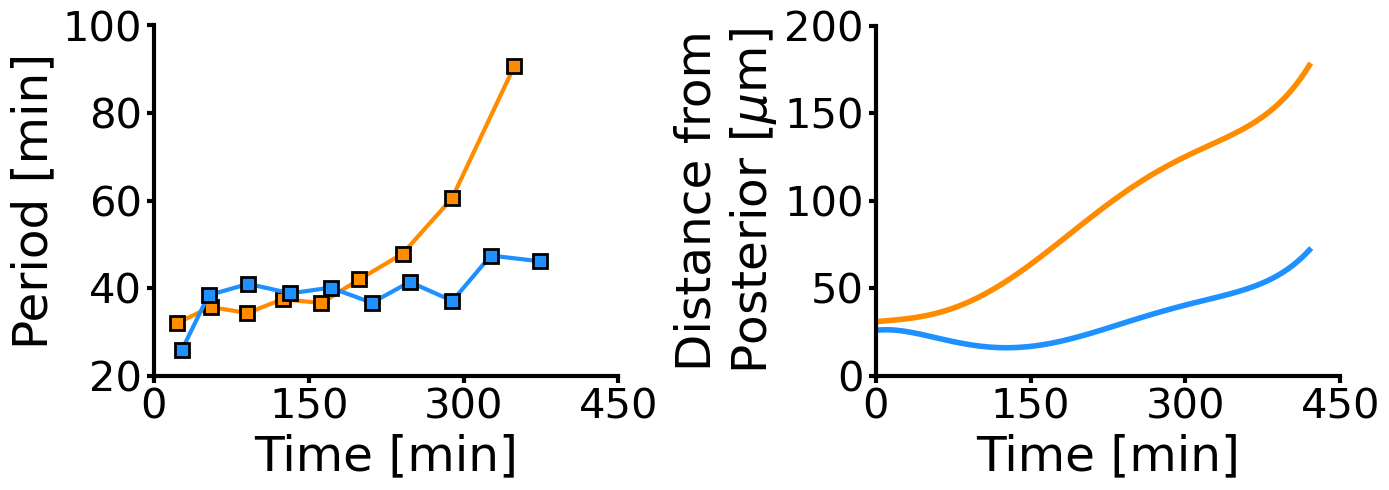

In [40]:
k = 0
deg = [5,5,3]
cols1 = ['darkorange', 'dodgerblue', 'deepskyblue']
fig = plt.figure(figsize=[14,5])

plt.subplot(122)
for k in range(2):
    x = np.arange(len(mean_vals_g[k]))*tr_min
    y = mean_vals_g[k]
    z = np.polyfit(x, y, deg[k])

    p = np.poly1d(z)
    xp = np.linspace(0,420,100)

    plt.plot(xp, p(xp), linewidth=4, color=cols1[k]) 
   

    #plt.axvline(75, linestyle='dashed')
plt.xlabel('Time [min]', fontsize=35)
plt.xticks(np.arange(0,550,150), fontsize=30)
plt.yticks(np.arange(0,250,50), fontsize=30)
plt.ylabel('Distance from\nPosterior [$\mu$m]', fontsize=35)
plt.xlim([0,450])
plt.ylim([0,200])


ax = plt.gca()
ax.tick_params(width=3, length=5)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(0)

plt.subplot(121)

plt.plot(peak_time[0][:-1]*tr_min, np.diff(peak_time[0])*tr_min, linewidth=3, label='TB-Somite', color='darkorange')
plt.plot(peak_time[0][:-1]*tr_min, np.diff(peak_time[0])*tr_min, marker='s', markeredgewidth=2, markersize=10, markeredgecolor='k', color='darkorange', alpha=1)

plt.plot(peak_time[1][:-1]*tr_min, np.diff(peak_time[1])*tr_min, linewidth=3, label='TB-PSM4', color='dodgerblue')
plt.plot(peak_time[1][:-1]*tr_min, np.diff(peak_time[1])*tr_min, marker='s', markeredgewidth=2, markersize=10, markeredgecolor='k', color='dodgerblue', alpha=1)



plt.yticks(np.arange(20,105,20), fontsize=30)
plt.ylabel('Period [min]', fontsize=35)
plt.xlim([0,450])

plt.xlabel('Time [min]', fontsize=35)
plt.xticks(np.arange(0,550,150), fontsize=30)



ax = plt.gca()
ax.tick_params(width=3, length=5)
ax.spines['top'].set_linewidth(0)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(0)

plt.tight_layout()
plt.show()

fig.savefig('../../Figures Linked Alt Version Nov 2021/ABR_Edits/Movement.pdf', bbox_inches='tight')

## Observe the spots on a Max Projection

<a id='max'></a>

Using Fiji, we have created Max-Projections of some timepoints which we use in Figure 1 to show the position of the cells in the AP axis during their progression through somitogenesis. 

If you want to go to the top of the notebook click: [TOP](#top)

In [24]:
# Time Point for the Max Projection

time_point = [0, 150, 300, 450]
cells_time_point = [10,100,200,298]

colors = ['orange','dodgerblue']

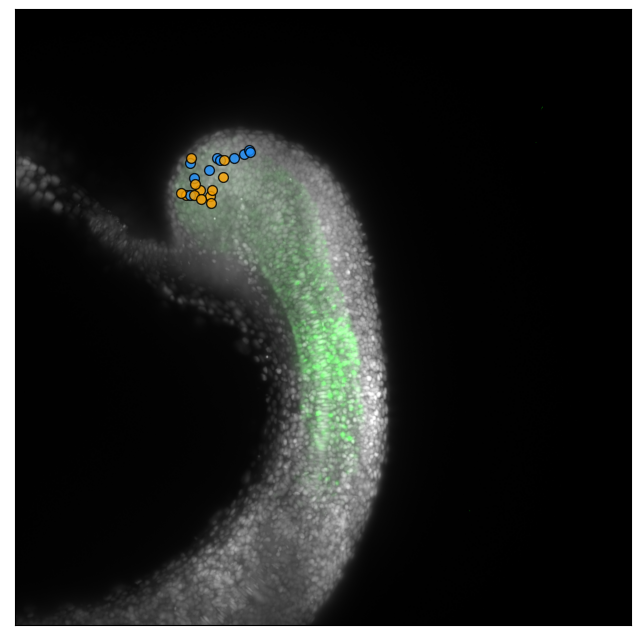

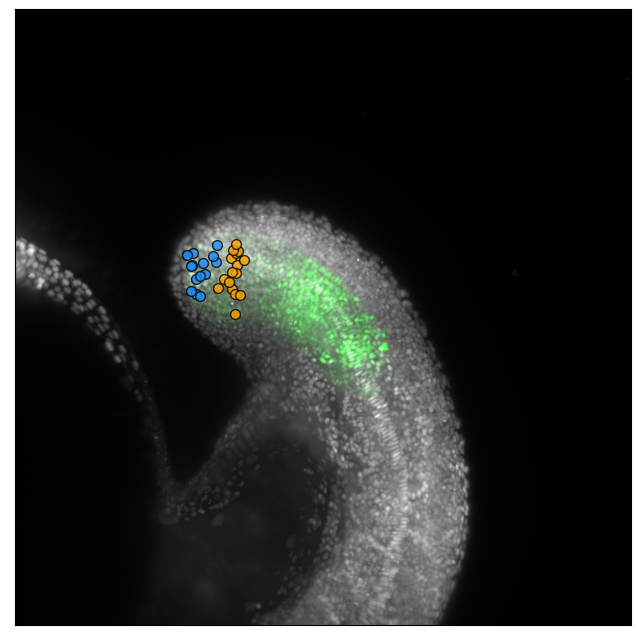

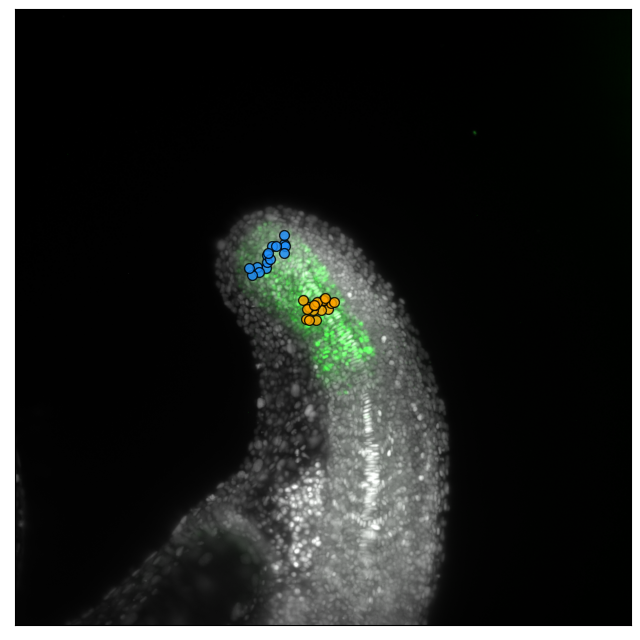

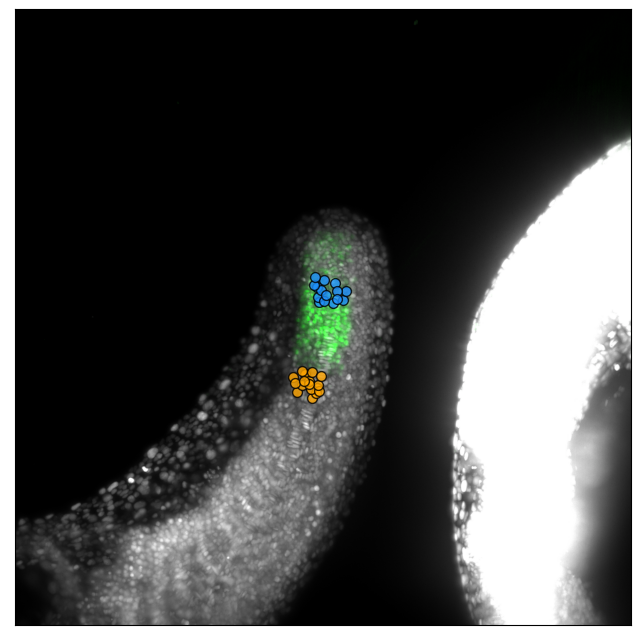

In [25]:
for i in range(4):
    image = tifffile.imread('%s/Time%dmin.tif'%(path_tif, time_point[i]))

    fig = plt.figure(figsize=[8,8])
    tp = cells_time_point[i]

    plt.imshow(image)


    colors = ['orange','dodgerblue']

    for j in range(tracks.n_tracks_divs):
        ind = int(tag_save[j])
        if ind != 2:
            plt.scatter(x_save_r[j][tp]/fts.x_pixel,y_save_r[j][tp]/fts.y_pixel, c=colors[ind], edgecolor='black', linewidth=1, s=50, alpha=0.8)

    plt.xlim([0,2048])
    plt.ylim([0,2048])

    plt.xticks([])
    plt.yticks([])
    fig.savefig('../Data/Figure 1/Figure 1A-E/Results/Max-Proj_Time%d_.pdf'%(tp-10),bbox_inches='tight', dpi=300)
    